# Quantum Teleportation

Quantum teleportation is a technique for moving quantum states around, even in the absence of a quantum communications channel linking the sender of the quantum state to the recipient.


Here’s how quantum teleportation works. Alice and Bob met long ago but now live far apart. While together they generated a Bell pair, each taking one qubit of the Bell pair when they separated. Many years later, Bob is in hiding, and Alice’s mission, should she choose to accept it, is to deliver a qubit $|\psi\rangle$ to Bob. She does not know the state of the qubit, and moreover can only send classical information to Bob. Should Alice accept the mission?

Alice doesn’t know the state $|\psi\rangle$ of the qubit she has to send to Bob, and the laws of quantum mechanics prevent her from determining the state when she only has a single copy of $|\psi\rangle$ in her possession. What’s worse, even if she did know the state $|\psi\rangle$, describing it precisely takes an infinite amount of classical information (theoretically speaking) - since $|\psi\rangle$ takes values in a continuous space. So even if she did know $|\psi\rangle$, it would take forever for Alice to describe the state to Bob. It’s not looking good for Alice. Fortunately for Alice, quantum teleportation is a way of utilizing the entangled Bell pair in order to send $|\psi\rangle$ to Bob, with only a small overhead of classical communication.



## The Quantum Teleportation Protocol 

Teleportation is achieved in four steps:

- **Initial state:** Alice starts with a quantum state $|\psi\rangle$ of a single qubit. Alice and Bob also share a quantum state of two qubits, $\frac{|00\rangle+|11\rangle}{\sqrt 2}$ (Bell Pair).


- **What Alice does:** To accomplish her part of the protocol, Alice performs a CNOT gate between $|\psi\rangle$ and her other qubit, then applies a Hadamard gate to the first qubit. Alice then measures both her qubits in the computational basis, getting results $z = 0$ or $1$ and $x = 0$ or $1$. The probability for each of the four possible measurement outcomes $ (00, 01, 10, 11) $ is $\frac{1}{4}$


- **Classical communication:** Alice sends both classical bits, $z$ and $x$, to Bob.


- **Bob recovers the quantum state $|\psi\rangle$:** Bob applies the Pauli X-gate ( NOT gate) to his qubit if and only if $x=1$ and he applies the Pauli Z-gate to his qubit if and only if $z = 1$.  This results in Bob recovering the original state $|\psi\rangle$.


One important point to note is that at the end of the teleportation protocol, only Bob possesses the quantum state $|\psi\rangle$. Alice no longer possesses the initial quantum state. 



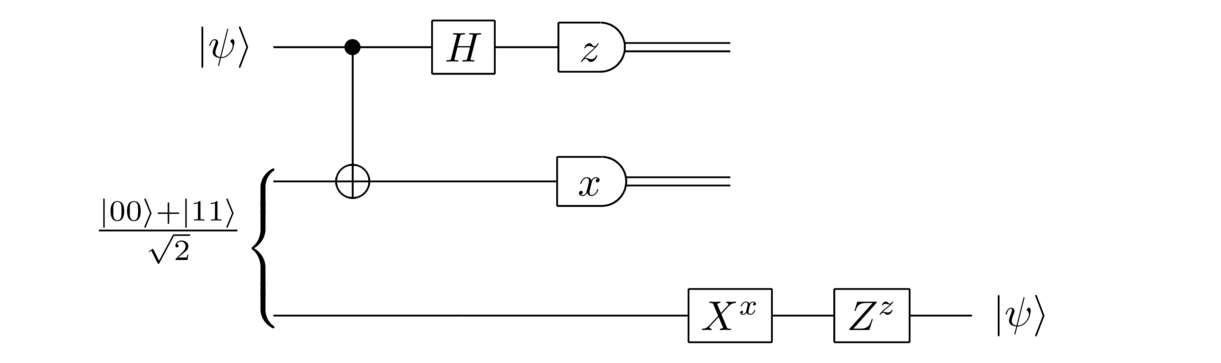

## Implementation in Amazon Braket

Let's see how we can implement quantum teleportation protocol in Amazon Braket

- Alice had the initial state to teleport in qubit-0. 
- We'll create an entangled Bell Pair with qubit-1 and qubit-2. Alice has qubit-1 and Bob has qubit-2
- Alice applies CNOT between qubit-0 and qubit-1 and then a Hadamard to qubit-0

- Depending on what Alice's measures on qubit-0 & qubit-1, Bob has to apply these gates...

|Alice's measurement|   Gates to apply|
|---|-----|
|00 | Nothing|
|01 |	X|
|10 |	Z|
|11 |	ZX|

- To simulate measuring Alice's qubits and passing the measurement outputs to Bob classically - we'll use CNOT and CZ gates to Bob's qubit-2 - which achieves the same result as above table without performing partial measurements.




In [1]:
from braket.circuits import Circuit
from braket.devices import LocalSimulator
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

device = LocalSimulator()

In [2]:
qt = Circuit()

# Prepare Initial State ( you can experiment with different states)

#qt.i(0)            # Initial State is 0
#qt.x(0)             # Initial State is 1
#qt.h(0)             # Initial State is a 50:50 superposition
#qt.h(0).t(0).h(0)     # Initial State is 85:15 superposition
qt.h(0).t(0).z(0).h(0) # Initial State is 15:85 superposition
#qt.ry(0, 2*np.pi/5)      # Initial State is 66:33 superposition
######



# Prepare a Bell state between qubits 1 & 2. Qubit 0 & 1 is with Alice. Qubit 2 is with Bob
qt.h(1).cnot(1, 2)

# Add CNOT and Hadamard to Alice's part of the circuit
qt.cnot(0, 1)
qt.h(0)


# Add conditional gates to Bob's Qubit
qt.cnot(1, 2)
qt.cz(0, 2)
print(qt)



T  : |0|1|2|3|4|5|6|
                    
q0 : -H-T-Z-H-C-H-C-
              |   | 
q1 : -H-C-----X-C-|-
        |       | | 
q2 : ---X-------X-Z-

T  : |0|1|2|3|4|5|6|


## Now run the circuit

In [3]:
task = device.run(qt,shots=1000)

In [4]:
result = task.result()
print(f"Measurement_counts of all 3 qubits: {result.measurement_counts}\n")

Measurement_counts of all 3 qubits: Counter({'101': 231, '011': 213, '001': 208, '111': 202, '000': 45, '110': 41, '010': 34, '100': 26})



To obtain the measurement results of just Bob's qubit (qubit-2), we'll extract just the qubit-2 measurement counts and plot the results.

Measurement of Bob's qubit: {'1': 854, '0': 146}



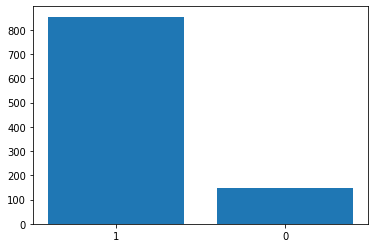

In [5]:

# Extract the measurement results of qubit 2 from the measurement counts for all three qubits
answer_plot = {}
for measresult in result.measurement_counts.keys():
    measresult_input = measresult[2:]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += result.measurement_counts[measresult]
    else:
        answer_plot[measresult_input] = result.measurement_counts[measresult] 

print(f"Measurement of Bob's qubit: {answer_plot}\n")
plt.bar(answer_plot.keys(), answer_plot.values())
plt.show()
        

#### We should see the expected probability distribution of the initial state in qubit 0 being measured in qubit 2 at the end.



---

### References

1. Andy Matuschak and Michael A. Nielsen, “How Quantum Teleportation Works”, https://quantum.country/teleportation, San Francisco (2019). 

2. M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

---